In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import optuna

TODO:
- Impute bathrooms DONE
- ceiling DONE
- area_living DONE
- area_kitchen DONE
- balconies and loggias DONE

In [3]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

In [56]:
all_data = pd.read_csv('all_data_h3.csv')

In [59]:
def rmlse(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

## Impute `bathrooms_total`

In [60]:
# Do not have en reasonable strategy other than using the mean.
all_data['bathrooms_total'] = all_data['bathrooms_total'].fillna(all_data.bathrooms_total.median())

## Impute `ceiling`

In [57]:
pd.set_option('display.max_rows', 500)
all_data.drop(columns = ['price', 'split', 'id', 'street', 'address']).apply(lambda x: x.corr(all_data.price)).sort_values()[-5:]

rooms                0.411317
log_area_total       0.560908
log_price_per_sqm    0.577837
area_living          0.707580
area_total           0.814829
dtype: float64

In [61]:
ceiling_fix2 = all_data.ceiling_fix
ceiling_fix2.loc[ceiling_fix2 < 1.6] = ceiling_fix2.mean()
ceiling_fix2.loc[ceiling_fix2 > 10] = ceiling_fix2.loc[ceiling_fix2 > 10]/10
all_data['ceiling_fix2'] = ceiling_fix2

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4)
imp = imputer.fit_transform(all_data[['longitude', 'latitude', 'ceiling_fix2']])
all_data['ceiling_fix2'] = imp[:, -1]

In [83]:
all_data['ceiling_fix2'] = all_data['ceiling_fix2'].fillna(all_data.ceiling_fix2.median())

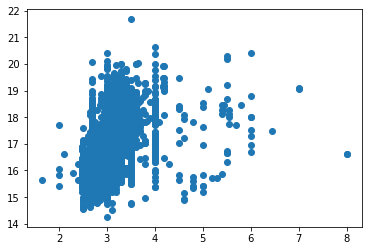

In [14]:
plt.scatter(all_data.ceiling_fix2, all_data.log_price)

In [9]:
mean = all_data.ceiling.mean()
high_ceil= np.zeros(all_data.shape[0])
for i in range(all_data.shape[0]):
    if not pd.isna(all_data.ceiling[i]) and all_data.ceiling[i] > mean:
        high_ceil[i] = 1

all_data['high_ceil'] = high_ceil


## Imputing `new`

In [80]:
isnew = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    if not pd.isna(data.new[i]) and data.new[i] == 1:
        isnew[i] = 1

data['isnew'] = isnew

<AxesSubplot:xlabel='isnew', ylabel='logprice'>

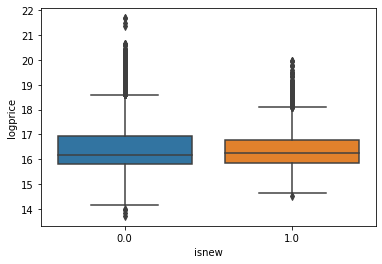

In [81]:
sns.boxplot(x = 'isnew', y = 'logprice', data = data)

In [87]:
new_const = data.loc[data.new == 1, 'constructed']
old_const = data.loc[data.new == 0, 'constructed']


<AxesSubplot:xlabel='constructed', ylabel='Count'>

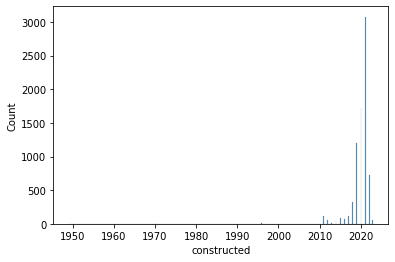

In [85]:
# new feature is bullshit
sns.histplot(new_const)

<AxesSubplot:xlabel='constructed', ylabel='Count'>

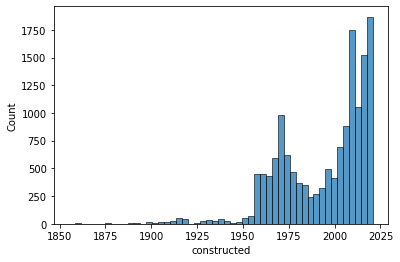

In [88]:
sns.histplot(old_const)

In [58]:
# Rather create new feature based on construction
new2 = np.zeros(all_data.shape[0])
for i in range(all_data.shape[0]):
    if not pd.isna(all_data.new[i]) and all_data.constructed[i] > 2000:
        new2[i] = 1

all_data['new2'] = new2

<AxesSubplot:xlabel='new2', ylabel='logprice'>

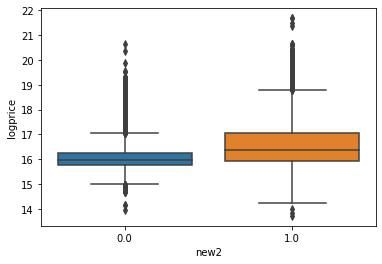

In [106]:
sns.boxplot(data = data, x = 'new2', y = 'logprice')

## Imputing `ballog`

In [63]:
all_data['ballog'] = all_data['ballog'].fillna(0)

## Impute `area_living`

In [64]:
pd.set_option('display.max_columns', 500)
area_living_fix = all_data.area_living
area_living_fix.loc[all_data.area_living > all_data.area_total]  = all_data.area_total/2

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [65]:
all_data['area_living_fix'] = area_living_fix

In [20]:
all_data.drop(columns = ['price', 'split', 'id', 'street', 'address', 'building_id', 'lon_rad', 'lat_rad', 'geometry']).apply(lambda x: x.corr(all_data.area_living)).sort_values()[-4:]

log_price         0.749629
log_area_total    0.801206
area_total        0.908238
area_living       1.000000
dtype: float64

In [84]:
from sklearn import linear_model
# Impute by regressing on the two most correlated features
missing_idx = all_data['area_living_fix'].isna()
model = linear_model.LinearRegression()
model.fit(X = all_data.loc[~missing_idx, ['area_total', 'rooms']], y = all_data.loc[~missing_idx, 'area_living_fix'])
all_data.loc[missing_idx, 'area_living_fix'] = model.predict(all_data.loc[missing_idx, ['area_total', 'rooms']])

## Imputing `area_kitchen`

In [67]:
area_kitchen_fix = all_data.area_kitchen
area_kitchen_fix.loc[all_data.area_kitchen > all_data.area_total]  = 0
all_data['area_kitchen_fix'] = area_kitchen_fix

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [117]:
all_data.drop(columns = ['price', 'split', 'id', 'street', 'address']).apply(lambda x: x.corr(all_data.area_kitchen)).sort_values()[-10:]

new                 0.263295
elevator_service    0.303741
bathrooms_shared    0.312293
rooms               0.316543
constructed         0.380721
seller              0.382460
area_living         0.390412
bathrooms_total     0.499980
area_total          0.525835
area_kitchen        1.000000
dtype: float64

In [68]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4)
imp = imputer.fit_transform(all_data[['longitude', 'latitude', 'area_kitchen_fix']])
all_data['area_kitchen_fix'] = imp[:, -1]

## Impute `parking`

In [89]:
# Assume that nan-values means no parking
# fill with 3 for now:
all_data['pariking'] = all_data['parking'].fillna(3)

## Imputing `garbage_chute`

In [70]:

all_data['garbage_chute'] = all_data['garbage_chute'].fillna(0)
#sns.boxplot(x = 'garbage_chute', y = 'logprice', data = data)

## Impute `heating`

In [71]:
# introduce new category for missing values
all_data['heating'] = all_data['heating'].fillna(4)

## Imputing `material`

In [72]:
# introduce new category for missing values
all_data['material'] = all_data['material'].fillna(6)

## Imputing `condition`

In [73]:
# introduce new category for missing values
all_data['condition'] = all_data['condition'].fillna(4)

## Creating feature for distance from city center

In [74]:
LAT_CENT = 55.751244
LON_CENT = 37.618423
dist = np.sqrt((all_data.latitude - LAT_CENT)**2 + (all_data.longitude - LON_CENT)**2)
all_data['center_distance'] = dist

In [75]:
data_train = all_data.loc[all_data.split == "train"]
data_test = all_data.loc[all_data.split == "test"]

## Average price per district 

# Export data

In [120]:
all_data.to_csv("imp_h1.csv")

In [134]:
all_data.

0        0
1        0
2        0
3        0
4        0
        ..
33217    0
33218    1
33219    0
33220    0
33221    0
Name: park_close, Length: 33222, dtype: int64

# Linear models

In [90]:
data_train = all_data.loc[all_data.split == "train"]
data_test = all_data.loc[all_data.split == "test"]

In [97]:

NUMERIC = ["latitude", "longitude", "constructed", "area_total", "area_living_fix", "area_kitchen_fix", "rooms", "ceiling_fix2",
            "center_distance", "park_distance", "metro_distance", "square_distance", "metro_close", "square_close", "park_close", "ballog", "bathrooms_total", "distr_avg",
            'khamo_dist', 'ostoz_dist', 'rublevka_dist', 'yaki_dist', 'arbat_dist', 'pres_dist', 'tver_dist']

CAT = [ "district", "material", "condition", "heating", "parking", "garbage_chute"]
FEATURES = NUMERIC + CAT

X_train = data_train[FEATURES].copy()
X_test = data_test[FEATURES].copy()

In [101]:
area_train = data_train.area_total
area_test = data_test.area_total

In [98]:
# transforming skewed features
from scipy.stats import skew

y = np.log(data_train.price)

#log transform skewed numeric features:

skewed_feats = X_train[NUMERIC].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
print(skewed_feats)

X_train[skewed_feats] = np.log1p(X_train[skewed_feats])
X_test[skewed_feats] = np.log1p(X_test[skewed_feats])

Index(['area_total', 'area_living_fix', 'area_kitchen_fix', 'rooms',
       'ceiling_fix2', 'center_distance', 'park_distance', 'metro_distance',
       'square_distance', 'metro_close', 'square_close', 'park_close',
       'ballog', 'bathrooms_total', 'distr_avg', 'khamo_dist', 'ostoz_dist',
       'yaki_dist', 'arbat_dist', 'pres_dist', 'tver_dist'],
      dtype='object')


In [99]:
X_train = pd.get_dummies(X_train, columns=CAT)
X_test = pd.get_dummies(X_test, columns=CAT)

In [95]:
X_train.isna().any()

latitude             False
longitude            False
constructed          False
area_total           False
area_living_fix      False
area_kitchen_fix     False
rooms                False
ceiling_fix2         False
center_distance      False
park_distance        False
metro_distance       False
square_distance      False
metro_close          False
square_close         False
park_close           False
ballog               False
bathrooms_total      False
distr_avg            False
khamo_dist           False
ostoz_dist           False
rublevka_dist        False
yaki_dist            False
arbat_dist           False
pres_dist            False
tver_dist            False
district_0.0         False
district_1.0         False
district_2.0         False
district_3.0         False
district_4.0         False
district_5.0         False
district_6.0         False
district_7.0         False
district_8.0         False
district_9.0         False
district_10.0        False
district_11.0        False
m

In [102]:
# linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
cv_scores = np.empty(5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for j, (train_idx, test_idx) in enumerate(kf.split(X_train, y)):
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_test = y[test_idx]
    y_train = y[train_idx]

    model.fit(X_tr, y_train)

    preds = np.exp(model.predict(X_te)) * area_train[test_idx]
    y_true = np.exp(y_test) * area_train[test_idx]
    cv_scores[j] = rmlse(y_true, preds)


In [103]:
cv_scores.mean()

0.24748679095261714

In [302]:
preds_test = np.exp(model.predict(X_test))
submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = preds_test
submission.to_csv('submissions/linreg.csv', index=False)

In [116]:
from sklearn.linear_model import Ridge
def cv_lasso(X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)
    alpha_grid = [1.0e-06, 1.0e-05, 1.9e-05, 2.0e-05, 1.0e-04, 0.001, 0.01, 0.1, 0.5, 0.8, 0.9, 1, 2, 3, 4]
    alpha_scores = np.zeros(len(alpha_grid))

    for i, alpha in enumerate(alpha_grid):
        model = Ridge(alpha = alpha)
        for j, (train_idx, test_idx) in enumerate(kf.split(X, y)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_test = y[test_idx]
            y_train = y[train_idx]

            model.fit(X_train, y_train)
        
            preds = np.exp(model.predict(X_test))
            y_true = np.exp(y_test)
            cv_scores[j] = rmlse(y_true, preds)
        alpha_scores[i] = cv_scores.mean()
    
    return alpha_grid, alpha_scores

In [ ]:
agrid, ascores = cv_lasso(X_train, y)

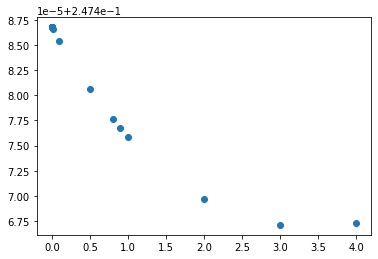

In [118]:
plt.scatter(agrid, ascores)

# KNN-regressor

In [92]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
X = data_train[['longitude', 'latitude', 'area_total']].copy()
#X['area_total'] = np.log(X.area_total)
y = data_train.price
train, test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = round(np.log(data_train.price)))

In [96]:
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [97]:
preds = neigh.predict(test)
rmlse(y_test, preds)

0.33125196445772653

In [451]:
X = data_train[['longitude', 'latitude', 'area_total']].copy()
X['area_total'] = np.log(X.area_total)
y = data_train.price

X_test = data_test[['longitude', 'latitude', 'area_total']].copy()
X_test['area_total'] = np.log(X_test.area_total)

In [72]:
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X, y)

NameError: name 'KNeighborsRegressor' is not defined

In [452]:
preds = neigh.predict(X_test)
submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = preds
submission.to_csv('submissions/knn.csv', index=False)


# Try some stacking.

In [121]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split

/Users/jimtotland/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [122]:
SEED = 42
NFOLDS = 5

def get_oof(clf, kf, x_train, y_train, x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [123]:
rf_params = {
    'n_estimators' : 100,
    'criterion': 'mse',
    'max_depth': None,
    'min_weight_fraction_leaf': 0.0,
    'max_features': 'auto',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'bootstrap':True,
    'oob_score': False,
    'n_jobs': None,
    'random_state': SEED,
    'verbose': 0,
    'warm_start': False,
    'ccp_alpha': 0.0,
    'max_samples': None
}

lgb_params = {
    'num_leaves': 10,
    'max_depth': 5, 
    'random_state':SEED, 
    'silent' : True, 
    'metric': 'mse',
    'n_jobs': 4, 
    'n_estimators': 2000,
    'colsample_bytree': 0.95,
    'subsample': 0.9,
    'learning_rate': 0.05
}

cb_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'thread_count': -1,
    'depth': 7,
    'silent': True,
    'random_seed': SEED,
    'bagging_temperature': 0.2
}

ada_params = {
    'n_estimators': 1000,
    'learning_rate':0.05,
    'loss': 'square',
    'random_state': SEED
}

tree_params = {
    'criterion': 'mse',
    'max_depth': 5,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'random_state': SEED
}

gb_params = {
    'learning_rate': 0.01,
    'n_estimators':2000,
    'subsample':1.0, 
    'criterion':'mse', 
    'min_samples_split':4, 
    'min_samples_leaf':2, 
    'min_weight_fraction_leaf':0.0, 
    'max_depth':9, 
    'min_impurity_decrease':0.0, 
    'init':None, 
    'random_state':42, 
    'max_features':None,
    'alpha':0.9,
    'verbose':0,
    'max_leaf_nodes':None,
    'warm_start':False,
    'validation_fraction':0.1,
    'n_iter_no_change':None,
    'tol':0.0001,
    'ccp_alpha': 0.0
}

In [124]:
model1 = RandomForestRegressor(**rf_params)
model2 = lgb.LGBMRegressor(**lgb_params)
model3 = CatBoostRegressor(**cb_params)
model4 = AdaBoostRegressor(**ada_params)
model5 = DecisionTreeRegressor(**tree_params)
model6 = LinearRegression()
model7 = GradientBoostingRegressor(**gb_params)

In [125]:
kf = KFold(n_splits=NFOLDS, shuffle=True,random_state=SEED) 

gb_oof_train, gb_oof_test = get_oof(model7, kf, X_train, y, X_test)
rf_oof_train, rf_oof_test = get_oof(model1, kf, X_train, y, X_test)
lgbm_oof_train, lgbm_oof_test = get_oof(model2, kf, X_train, y, X_test)
cb_oof_train, cb_oof_test = get_oof(model3, kf, X_train, y, X_test)
ada_oof_train, ada_oof_test = get_oof(model4, kf, X_train, y, X_test)
tree_oof_train, tree_oof_test = get_oof(model5, kf, X_train, y, X_test)
linreg_oof_train, linreg_oof_test = get_oof(model6, kf, X_train, y, X_test)

In [126]:
x_train = np.concatenate((
            rf_oof_train,
            lgbm_oof_train,
            cb_oof_train,
            ada_oof_train,
            tree_oof_train,
            linreg_oof_train,
            gb_oof_train
        ), axis=1)

x_test = np.concatenate((
    rf_oof_test,
    lgbm_oof_test,
    cb_oof_test,
    ada_oof_test,
    tree_oof_test,
    linreg_oof_test,
    gb_oof_test
), axis=1)

In [142]:
#LGB meta model

META_MODEL = lgb.LGBMRegressor(
    num_leaves=5,
    max_depth=7, 
    random_state=SEED, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=2500,
    colsample_bytree=1,
    subsample=0.9,
    learning_rate=0.002
)

META_MODEL.fit(x_train, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              importance_type='split', learning_rate=0.002, max_depth=7,
              metric='mse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=2500, n_jobs=4, num_leaves=5,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [391]:
# XGB meta model.
param = {
        'max_depth': 3, 
        'reg_alpha': 0.0012, 'reg_lambda': 0.003, 
        'min_child_weight': 0, 'gamma': 2, 
        'learning_rate': 0.0132, 'colsample_bytree': 0.45
        }

dtrain = xgb.DMatrix(x_train, label = y)
META_MODEL = xgb.train(param, dtrain, num_boost_round=2000)

In [392]:
dtest = xgb.DMatrix(x_test)
preds = np.exp(META_MODEL.predict(dtest))
submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = preds
submission.to_csv('submissions/stack.csv', index=False)

In [143]:
preds = np.exp(META_MODEL.predict(x_test))
submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = preds
submission.to_csv('submissions/stack.csv', index=False)

In [144]:
submission

,id,price_prediction
0,23285,2.894686e+07
1,23286,9.644968e+06
2,23287,6.136317e+06
3,23288,8.141670e+06
4,23289,5.445709e+06
...,...,...
9932,33217,2.959119e+07
9933,33218,1.701111e+07
9934,33219,9.760407e+06
9935,33220,8.859670e+06


In [133]:
data_test

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,split,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,geometry,lon_rad,lat_rad,metro_distance,park_distance,park_close,square_distance,square_close,rublevka_dist,ostoz_dist,khamo_dist,yaki_dist,arbat_dist,pres_dist,tver_dist,metro_close,bathrooms_total,ballog,ceiling_fix,price_per_sqm,distr_avg,log_area_total,log_area_per_room,floor_fix,ceiling_fix2,area_living_fix,area_kitchen_fix,pariking,center_distance
23285,23285,NaN,NaN,71.4,NaN,35.365399,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,5148,test,0.0,55.762247,37.549040,0.0,2-я Черногрязская улица,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0,POINT (37.54904000000001 55.762247),0.655354,0.973235,825.809315,2072.586392,0,2407.762678,3,18336.173653,3814.598372,3623.697964,5061.042878,3469.959055,676.059132,3787.368503,1,1.0,1.0,NaN,NaN,546695.648414,4.268298,4.268298,2.0,2.800000,35.365399,15.00,3.0,0.070250
23286,23286,NaN,NaN,54.0,4.0,50.000000,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290,test,0.0,55.591467,37.452651,11.0,улица Сервантеса,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0,POINT (37.452651 55.591467),0.653672,0.970254,1319.278050,7744.119969,0,11872.826577,0,20383.167519,18846.877247,17513.052973,18593.027944,20099.918140,20303.257578,22077.317666,0,1.0,0.0,3.000000,NaN,143188.100942,3.988984,3.988984,4.0,3.000000,50.000000,4.00,0.0,0.230237
23287,23287,3.0,NaN,39.4,19.6,11.200000,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,4.0,1.0,681,test,1.0,55.617017,37.413718,11.0,Саларьево Парк ЖК,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,0.0,4.0,POINT (37.413718 55.617017),0.652993,0.970700,903.397736,9625.311029,0,11584.208621,0,16646.994374,17859.627463,16390.199123,17853.287368,19032.253681,18707.900725,20889.657826,1,1.0,0.0,2.650000,NaN,143188.100942,3.673766,3.673766,9.0,2.650000,11.200000,19.60,1.0,0.244788
23288,23288,NaN,NaN,60.9,NaN,33.265374,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261,test,0.0,55.569052,37.479510,11.0,улица Александры Монаховой,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0,POINT (37.47951 55.569052),0.654141,0.969863,1195.976230,7696.799446,0,13213.870184,0,23391.277752,20409.449809,19194.934141,19993.720319,21690.962451,22232.258337,23715.046143,0,1.0,0.0,NaN,NaN,143188.100942,4.109233,3.416086,5.0,2.800000,33.265374,12.15,3.0,0.229109
23289,23289,NaN,NaN,34.0,9.0,17.000000,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530,test,0.0,55.518041,37.343829,11.0,улица 3-я Нововатутинская,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0,POINT (37.343829 55.518041),0.651773,0.968973,9134.298106,17865.884248,0,22511.206947,0,25106.856842,29362.020138,27966.281283,29183.586713,30589.056332,30498.241458,32520.735050,0,1.0,1.0,2.750000,NaN,143188.100942,3.526361,3.526361,14.0,2.750000,17.000000,9.00,3.0,0.360258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33217,33217,3.0,NaN,106.0,19.9,56.700000,16.0,3.0,NaN,3.30,NaN,NaN,NaN,NaN,0.0,1.0,4.0,1.0,4252,test,1.0,55.789750,37.456468,8.0,улица Паршина,10А,2020.0,2.0,20.0,0.0,1.0,1.0,0.0,0.0,0.0,POINT (37.456468 55.78975),0.653739,0.973715,2149.619209,2722.553236,0,8714.902036,0,13592.771015,10312.574310,9724.912026,11543.178069,9995.091603,7056.500290,9746.268744,0,1.0,1.0,3.300000,NaN,232640.356084,4.663439,3.564827,16.0,3.300000,56.700000,19.90,0.0,0.166470
33218,33218,NaN,NaN,82.0,NaN,48.287121,3.0,3.0,NaN,NaN,2.0,0.0,1.0,0.0,NaN,NaN,1.0,2.0,7380,test,1.0,55.751639,37.516260,7.0,Западный Порт ЖК,к1,2021.0,2.0,20.0,0.0,1.0,1.0,1.0,0.0,4.0,POINT (37.51626 55.751639),0.654782,0.973050,631.967077,1016

In [349]:
def objective(trial, X, y):

    param = {   'booster': 'gbtree',
                'max_depth':trial.suggest_int('max_depth', 1, 11),
                'reg_alpha':trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
                'reg_lambda':trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.001,0.5),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
                'nthread' : -1
    }
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        kf = KFold(
            n_splits=NFOLDS,
            shuffle=True,
            random_state=SEED
        ) 

        dtrain = xgb.DMatrix(X_train, label=y_train)
        META_MODEL = xgb.train(param, dtrain, 
                                num_boost_round=1000)

        dtest = xgb.DMatrix(X_test)
        preds = np.exp(META_MODEL.predict(dtest)) 
        y_true = np.exp(y_test)
        cv_scores[idx] = rmlse(y_true, preds)

    return np.mean(cv_scores)

In [350]:
study = optuna.create_study(direction="minimize", study_name="Stack")
func = lambda trial: objective(trial, x_train, y)
study.optimize(func, n_trials=10)

[I 2021-11-09 14:34:40,544] A new study created in memory with name: Stack
[I 2021-11-09 14:35:25,246] Trial 0 finished with value: 0.14359774189705152 and parameters: {'max_depth': 3, 'reg_alpha': 0.05016170687237439, 'reg_lambda': 1.8409016717703767e-07, 'min_child_weight': 1, 'gamma': 0, 'learning_rate': 0.07685304923301955, 'colsample_bytree': 0.84}. Best is trial 0 with value: 0.14359774189705152.
[I 2021-11-09 14:37:07,437] Trial 1 finished with value: 0.1469716296421057 and parameters: {'max_depth': 8, 'reg_alpha': 9.814099441526654e-06, 'reg_lambda': 0.006447914672796177, 'min_child_weight': 2, 'gamma': 3, 'learning_rate': 0.07580301008496847, 'colsample_bytree': 0.58}. Best is trial 0 with value: 0.14359774189705152.
[I 2021-11-09 14:37:33,092] Trial 2 finished with value: 0.19573610780300438 and parameters: {'max_depth': 2, 'reg_alpha': 3.0247227897893424e-06, 'reg_lambda': 6.939181180876434e-05, 'min_child_weight': 5, 'gamma': 3, 'learning_rate': 0.004806372915925098, 'colsa

In [351]:
dtrain = xgb.DMatrix(x_train, label= y)
META_MODEL = xgb.train(study.best_params, dtrain, num_boost_round=1000)

In [352]:
dtest = xgb.DMatrix(x_test)
preds = np.exp(META_MODEL.predict(dtest))
submission = pd.DataFrame()
submission['id'] = data_test.index
submission['price_prediction'] = preds
submission.to_csv('submissions/stack.csv', index=False)